In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
# from wandb.apis.importers.mlflow import MlflowImporter
import wandb
api = wandb.Api()

## WandB Api

In [3]:
api.run("xnf/mt3_res256/1xnmivvi")
runs = dict()
# runs[1.0] = 
runs[1.25] = api.run("xnf/mt3_res256/yb6ei4o8")
runs[1.5] = api.run("xnf/mt3_res256/bcf4hn1t")
runs[2.0] = api.run("xnf/mt3_res256/a4hrvcxr")
runs[3.0] = api.run("xnf/mt3_res256/wva6n5nc")
runs[6.0] = api.run("xnf/mt3_res256/ye2srrrx")
runs[9.0] = api.run("xnf/mt3_res256/dhyh0orl")

In [8]:
fids = dict()
recall_lst = dict()
fscores = dict()
for cfg, run in runs.items():
    history = run.history()
    history = history[history.ckpt_step == 320000]
    fid = history['eval-10000-50/fid'].values[0]
    precision = history['eval-10000-50/precision'].values[0]
    recall = history['eval-10000-50/recall'].values[0]
    fscore = 2 * precision * recall / (precision + recall)

    fids[cfg] = fid
    recall_lst[cfg] = recall
    fscores[cfg] = fscore
    print(f"cfg={cfg:.2f}\t fid={fid:.3f}, rec={recall:.3f}, prec={precision:.3f} f-score={fscore:.3f}")

cfg=1.00	 fid=76.996, rec=0.289, prec=0.427 f-score=0.345
cfg=1.25	 fid=66.178, rec=0.337, prec=0.439 f-score=0.381
cfg=1.50	 fid=57.450, rec=0.396, prec=0.456 f-score=0.424
cfg=2.00	 fid=44.318, rec=0.491, prec=0.483 f-score=0.487
cfg=3.00	 fid=31.486, rec=0.633, prec=0.465 f-score=0.536
cfg=6.00	 fid=24.777, rec=0.773, prec=0.320 f-score=0.452
cfg=9.00	 fid=25.090, rec=0.816, prec=0.249 f-score=0.381


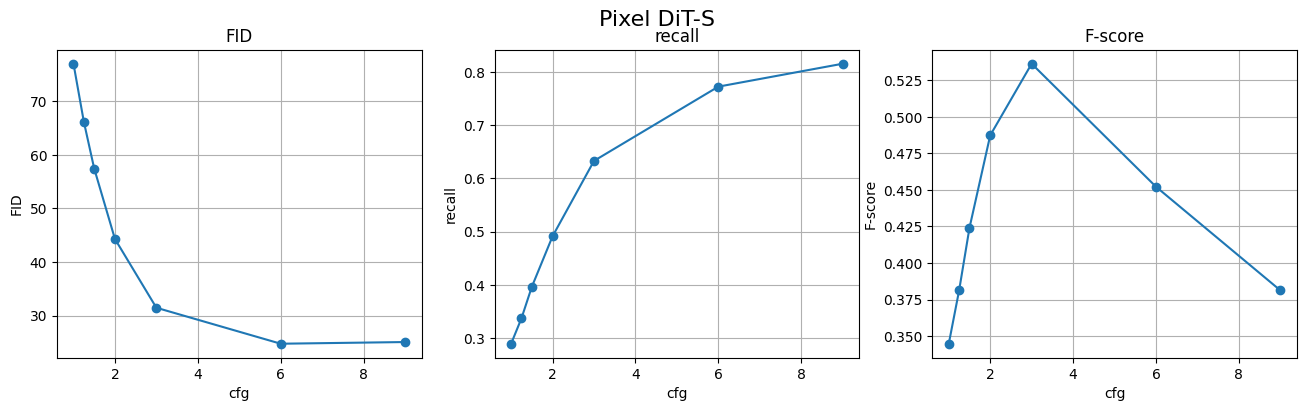

In [9]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
for i, (name, data) in enumerate([("FID", fids), ("recall", recall_lst), ("F-score", fscores)]):
    ax = axes[i]
    ax.plot(data.keys(), data.values(), marker='o')
    ax.set_xlabel('cfg')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.grid()
fig.suptitle("Pixel DiT-S", fontsize=16)
plt.show()

# Read from metrics.npy file

In [2]:
def get_checkpoint_path(expr_name):
    if os.path.exists(f'/mnt/disks/gs2/outputs/checkpoints/{expr_name}'):
        expr_path = f'/mnt/disks/gs2/outputs/checkpoints/{expr_name}'
        checkpoint_path = f'{expr_path}/checkpoints'
        assert os.path.exists(checkpoint_path), f"Experiment found, but checkpoints not found in gs2"
    elif os.path.exists(f'/mnt/disks/gs1/outputs/checkpoints/{expr_name}'):
        expr_path = f'/mnt/disks/gs2/outputs/checkpoints/{expr_name}'
        checkpoint_path = f'{expr_path}/checkpoints'
        assert os.path.exists(checkpoint_path), f"Experiment found, but checkpoints not found in gs1"
    else:
        raise ValueError(f"Experiment {expr_name} not found in gs1 or gs2")
    return checkpoint_path

def get_samples_path(expr_name, checkpoint):
    if os.path.exists(f'/mnt/disks/gs2/outputs/checkpoints/{expr_name}'):
        expr_path = f'/mnt/disks/gs2/outputs/checkpoints/{expr_name}'
        samples_path = f'{expr_path}/samples/{checkpoint}'
        if not os.path.exists(samples_path):
            print(f"Experiment found, but sample for {checkpoint} not found in gs2")
            return False
    elif os.path.exists(f'/mnt/disks/gs1/outputs/checkpoints/{expr_name}'):
        expr_path = f'/mnt/disks/gs1/outputs/checkpoints/{expr_name}'
        samples_path = f'{expr_path}/samples/{checkpoint}'
        if not os.path.exists(samples_path):
            print(f"Experiment found, but sample for {checkpoint} not found in gs1")
            return False
    else:
        raise ValueError(f"Experiment {expr_name} not found in gs1 or gs2")
    return samples_path


def get_npz_path(samples_path, suffix):
    npzpath = [p for p in os.listdir(samples_path) if p.endswith(suffix+'.npz')]
    if len(npzpath) == 0:
        return False
    elif len(npzpath) > 1:
        import pdb; pdb.set_trace()
    else:
        return os.path.join(samples_path, npzpath[0])

def get_metric_path(samples_path, suffix):
    metricpath = [p for p in os.listdir(samples_path) if p.endswith(suffix+'-metrics.npy')]
    if len(metricpath) == 0:
        return False
    elif len(metricpath) > 1:
        import pdb; pdb.set_trace()
    else:
        return os.path.join(samples_path, metricpath[0])


In [3]:
def plot_cfg_sweep(expr_name, checkpoints, cfgs, expr_config, fig, axes, plot_kwargs={}):

    nsmp = expr_config['nsmp']
    step = expr_config['step']
    seed = expr_config['seed']
    mode = expr_config['mode']

    for checkpoint in checkpoints:
        samples_path = get_samples_path(expr_name, checkpoint)
        fids = dict()
        fscores = dict()
        inception_scores = dict()
        precisions = dict()
        recalls = dict()
        
        for cfg in cfgs:
            folder_suffix = f"cfg-{cfg}-seed-{seed}-step-{step}-nsmp-{nsmp}-{mode if mode!='ddpm' else ''}"
            metric_path = get_metric_path(samples_path, folder_suffix)
            if metric_path:
                metric = np.load(metric_path, allow_pickle=True).item()
                fids[cfg] = metric[f'eval-{nsmp}-{step}/fid']
                inception_scores[cfg] = metric[f'eval-{nsmp}-{step}/inception']
                precision = metric[f'eval-{nsmp}-{step}/precision']
                precisions[cfg] = precision
                recall = metric[f'eval-{nsmp}-{step}/recall']
                recalls[cfg] = recall
                fscores[cfg] = 2 * precision * recall / (precision + recall)
        
        for i, (name, data) in enumerate([("FID", fids), ("Inception Score", inception_scores), ("F-score", fscores), ("Recall", recalls)]):
            ax = axes[i]
            if i==0: label=f"{expr_config['nickname']}-{checkpoint//1000}k"
            else: label=""
            ax.plot(data.keys(), data.values(), marker='o', label=label, **plot_kwargs)
            ax.set_xlabel('cfg')
            ax.set_ylabel(name)
            ax.set_title(name)
            ax.grid('on')
    
    return fig, axes

def plot_step_sweep(expr_name, checkpoints, steps, expr_config, fig, axes, plot_kwargs={}):

    nsmp = expr_config['nsmp']
    cfg = expr_config['cfg']
    seed = expr_config['seed']
    mode = expr_config['mode']

    for checkpoint in checkpoints:
        samples_path = get_samples_path(expr_name, checkpoint)
        fids = dict()
        fscores = dict()
        inception_scores = dict()
        precisions = dict()
        recalls = dict()
        
        for step in steps:
            folder_suffix = f"cfg-{cfg}-seed-{seed}-step-{step}-nsmp-{nsmp}-{mode if mode!='ddpm' else ''}"
            metric_path = get_metric_path(samples_path, folder_suffix)
            if metric_path:
                metric = np.load(metric_path, allow_pickle=True).item()
                metric_prefix = f'eval-{nsmp}-{step}' if step!=256 else f'eval-{nsmp}'
                fids[step] = metric[f'{metric_prefix}/fid']
                print(f'expr name: {expr_name}, checkpoint: {checkpoint}, step: {step}, FID: {fids[step]}')
                inception_scores[step] = metric[f'{metric_prefix}/inception']
                precision = metric[f'{metric_prefix}/precision']
                precisions[step] = precision
                recall = metric[f'{metric_prefix}/recall']
                recalls[step] = recall
                fscores[step] = 2 * precision * recall / (precision + recall)
        
        for i, (name, data) in enumerate([("FID", fids), ("Inception Score", inception_scores), ("F-score", fscores), ("Recall", recalls)]):
            ax = axes[i]
            if i==0: label=f"{expr_config['nickname']}-{checkpoint//1000}k"
            else: label=""
            ax.plot(data.keys(), data.values(), marker='o', label=label, **plot_kwargs)
            ax.set_xlabel('sampling steps')
            ax.set_ylabel(name)
            ax.set_title(name)
            ax.grid('on')
    
    return fig, axes

## Cfg sweep

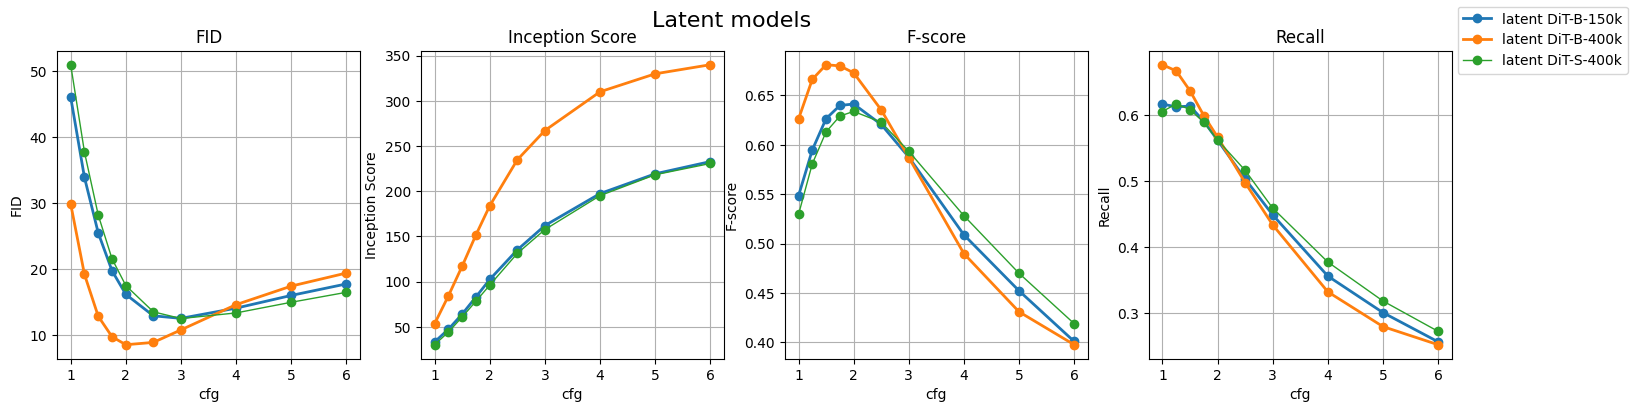

In [4]:
fig, axes = plt.subplots(1,4, figsize=(18,4))

expr_name = 'rectflow-lognorm/latent/ps1-DiT-B-2024-Aug-27-17-50-52'
expr_config = {'seed': 0, 'step': 50, 'nsmp': 10000, 'mode': 'rectflow', 'nickname': 'latent DiT-B'}
checkpoints = [150000, 400000]
cfgs = [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0]
fig, axes = plot_cfg_sweep(expr_name, checkpoints, cfgs, expr_config, fig, axes, plot_kwargs={'linewidth': 2})

expr_name = 'rectflow-lognorm/latent/ps1-DiT-S-2024-Aug-22-20-28-33'
expr_config = {'seed': 0, 'step': 50, 'nsmp': 10000, 'mode': 'rectflow', 'nickname': 'latent DiT-S'}
checkpoints = [400000]
cfgs = [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0]
fig, axes = plot_cfg_sweep(expr_name, checkpoints, cfgs, expr_config, fig, axes, plot_kwargs={'linewidth': 1})

fig.legend()
plt.suptitle('Latent models', fontsize=16)
plt.show()

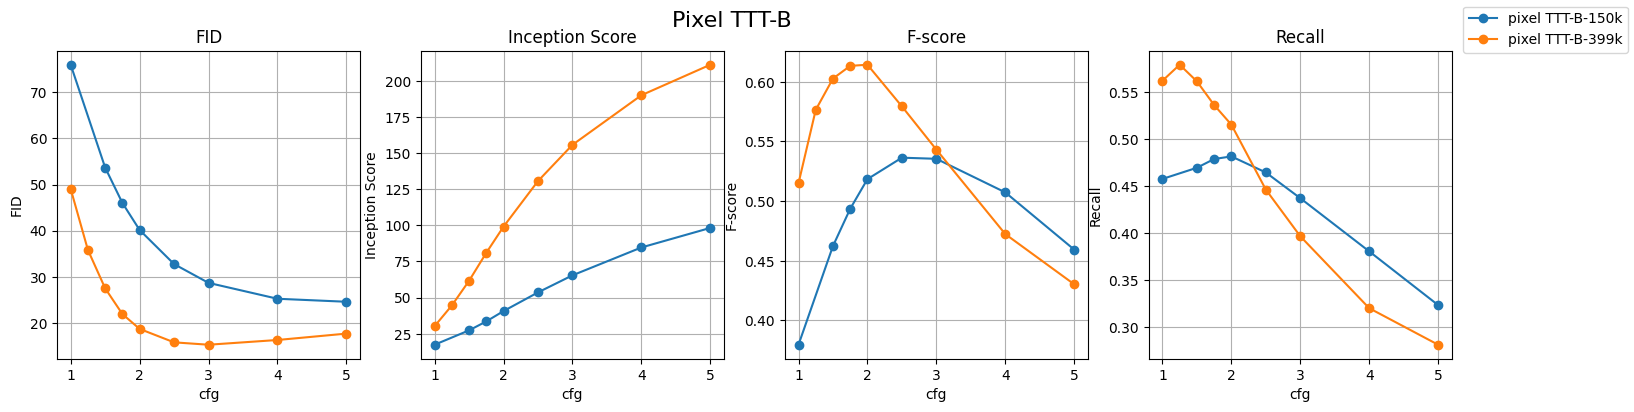

In [4]:
fig, axes = plt.subplots(1,4, figsize=(18,4))

# expr_name = 'rectflow-lognorm/t3lm-mlp-bd-fixed/pixels/ps2-DiT-S-mt3lm-mlp-bd-2024-Aug-24-00-08-40'
# expr_config = {'seed': 0, 'step': 50, 'nsmp': 10000, 'mode': 'rectflow', 'nickname': 'pixel TTT-S'}
# checkpoints = [320000]
# cfgs = [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 9.0]
# fig, axes = plot_cfg_sweep(expr_name, checkpoints, cfgs, expr_config, fig, axes, plot_kwargs={'linewidth': 2, 'linestyle': '-'})

expr_name = 'ttt/pixels/ps2-TTT-B-lmbd-mlp-2024-Sep-05-07-27-42'
expr_config = {'seed': 0, 'step': 50, 'nsmp': 10000, 'mode': 'rectflow', 'nickname': 'pixel TTT-B'}
checkpoints = [150000, 399999]
cfgs = [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0]
fig, axes = plot_cfg_sweep(expr_name, checkpoints, cfgs, expr_config, fig, axes)

fig.legend()
plt.suptitle('Pixel TTT-B', fontsize=16)
plt.show()

## sampling steps sweep

expr name: ttt/pixels/ps2-TTT-B-lmbd-mlp-2024-Sep-05-07-27-42, checkpoint: 480000, step: 50, FID: 45.406727061565675
expr name: ttt/pixels/ps2-TTT-B-lmbd-mlp-2024-Sep-05-07-27-42, checkpoint: 480000, step: 128, FID: 43.423502497493246
expr name: ttt/pixels/ps2-TTT-B-lmbd-mlp-2024-Sep-05-07-27-42, checkpoint: 480000, step: 256, FID: 42.96747368928533
expr name: ttt/pixels/ps2-TTT-B-lmbd-mlp-2024-Sep-05-07-27-42, checkpoint: 480000, step: 512, FID: 42.59978302828199
expr name: rectflow-lognorm/latent/ps1-DiT-S-2024-Aug-22-20-28-33, checkpoint: 500000, step: 50, FID: 46.85013547773218
expr name: rectflow-lognorm/latent/ps1-DiT-S-2024-Aug-22-20-28-33, checkpoint: 500000, step: 128, FID: 45.78984504561686
expr name: rectflow-lognorm/latent/ps1-DiT-S-2024-Aug-22-20-28-33, checkpoint: 500000, step: 256, FID: 45.500302151707785
expr name: rectflow-lognorm/latent/ps1-DiT-S-2024-Aug-22-20-28-33, checkpoint: 500000, step: 512, FID: 45.31072668718133
expr name: rectflow-lognorm/latent/ps1-DiT-S-20

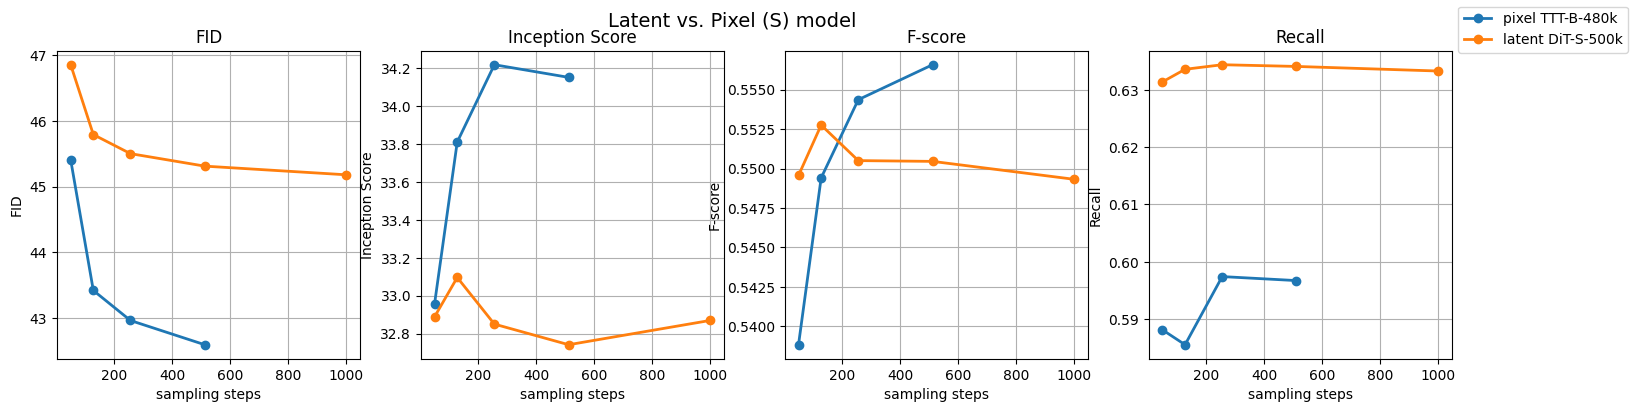

In [4]:
fig, axes = plt.subplots(1,4, figsize=(18,4))

# expr_name = 'ttt/pixels/ps2-TTT-S-lmbd-mlp-2024-Sep-04-21-16-01'
# expr_config = {'seed': 0, 'cfg': 1.0, 'nsmp': 10000, 'mode': 'rectflow', 'nickname': 'pixel TTT-S'}
# checkpoints = [500000]
# steps = [50, 128, 256, 512, 1000]
# fig, axes = plot_step_sweep(expr_name, checkpoints, steps, expr_config, fig, axes, plot_kwargs={'linewidth': 2})


expr_name = 'ttt/pixels/ps2-TTT-B-lmbd-mlp-2024-Sep-05-07-27-42'
expr_config = {'seed': 0, 'cfg': 1.0, 'nsmp': 10000, 'mode': 'rectflow', 'nickname': 'pixel TTT-B'}
checkpoints = [480000]
steps = [50, 128, 256, 512]
fig, axes = plot_step_sweep(expr_name, checkpoints, steps, expr_config, fig, axes, plot_kwargs={'linewidth': 2})

expr_name = 'rectflow-lognorm/latent/ps1-DiT-S-2024-Aug-22-20-28-33'
expr_config = {'seed': 0, 'cfg': 1.0, 'nsmp': 10000, 'mode': 'rectflow', 'nickname': 'latent DiT-S'}
checkpoints = [500000]
steps = [50, 128, 256, 512, 1000]
fig, axes = plot_step_sweep(expr_name, checkpoints, steps, expr_config, fig, axes, plot_kwargs={'linewidth': 2})

fig.legend()
plt.suptitle('Latent vs. Pixel (S) model', fontsize=14)
plt.show()